<a href="https://colab.research.google.com/github/cpvivek/Facial-Emotion-Recognition/blob/main/Capstone_DL%26MLE_Facial_Emotion_Recognition_Vivek_CP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Facial Emotion Detection
The objective of this project is to develop a CNN model to perform facial emotion recognition on human faces, and deploy a web app to perform this task in real time.

Importing necessary libraries including tensorflow, keras, sklearn and opencv

In [2]:
# import necessary files
import cv2
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import keras
import tensorflow as tf
from keras.utils import np_utils
from keras.models import Sequential 
from keras.layers import Dense, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten

Importing dataset sourced from kaggle

In [4]:
# mounting drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


reading the csv file.

In [5]:
df = pd.read_csv('/content/drive/MyDrive/Alma Better Pro/Alma Better Pro Program/Module 4: Machine Learning/Data Sets/icml_face_data.csv')

#EDA

Let's look into our dataset

In [ ]:
df.columns

Index(['emotion', ' Usage', ' pixels'], dtype='object')

So the dataset is not all that complicated.

We've got 'emotion' field indicating different emotions.

I believe since this is a dataset used in kaggle competitions, they've went ahead and done the training, validation and test segregation, labeled by 'Usage' column

And finally in the 'pixels' field, we have the pixelated form of the image, flattened into an 1 dimension array. 

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  35887 non-null  int64 
 1    Usage   35887 non-null  object
 2    pixels  35887 non-null  object
dtypes: int64(1), object(2)
memory usage: 841.2+ KB


The pixel field is stored as a string at the moment. We'll have to convert that into a 48x48x1 array with float values.

In [6]:
#using lambda function to achieve this conversion
df[' pixels']=df[' pixels'].apply(lambda x: np.fromstring(x, sep=' ',dtype='float32')) #converting string to float separated by ' ' 
df[' pixels']=df[' pixels'].apply(lambda x:np.asarray(x.reshape(48,48,1))) #reshaping to 48x48x1

Let's look into emotions field.

In [ ]:
df['emotion'].unique()

array([0, 2, 4, 6, 3, 5, 1])

The dataset contains 7 different emotions labeled using number from 0 to 6.

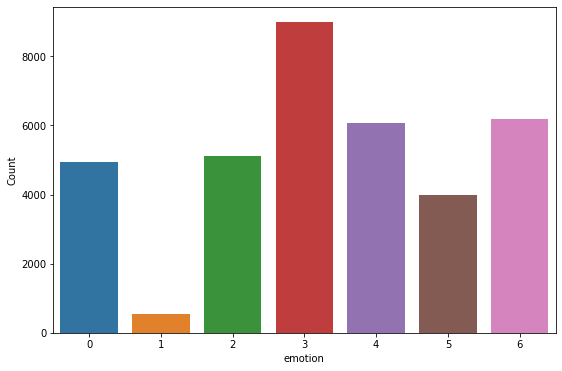

In [27]:
emotion_count=df.groupby('emotion').count().rename(columns={' Usage':'Count'}).drop(' pixels',axis=1).reset_index()
plt.figure(figsize=(9,6))
sns.barplot(x=emotion_count['emotion'],y=emotion_count['Count'])
plt.show()

We can observe that the number of images corresponding to each images is quite imbalanced.This will create an bias in model towards certain emotions.
So we'd have to perform some image augmentation in the training set to tackle this issue.

Let's segregate our training, validation and test sets right away. 

Public Test would be put into validation and Private test into test set. 

In [7]:
emotion_dict = {0: 'Angry', 1: 'Disgusted', 2: 'Fearful', 3: 'Happy', 4: 'Sad',5: 'Suprised', 6: 'Neutral'}
classes = np.array(("Angry", "Disgusted", "Fearful", "Happy", "Sad", "Surprised", "Neutral"))

In [ ]:
df[' Usage'].value_counts()

Training       28709
PublicTest      3589
PrivateTest     3589
Name:  Usage, dtype: int64

In [8]:
#defininng train, val and test data.
training_data=df[df[' Usage']=='Training']
validation_data=df[df[' Usage']=='PublicTest']
testing_data=df[df[' Usage']=='PrivateTest']

In [ ]:
training_data['emotion'].value_counts()

3    7215
6    4965
4    4830
2    4097
0    3995
5    3171
1     436
Name: emotion, dtype: int64

x_train, y_train formation


In [9]:
x_train=[]
for i in range(len(training_data[' pixels'])):
  x_train.append(training_data[' pixels'][i])
x_train=np.asarray(x_train) #since we need arrays as input to CNN 
x_train=x_train.reshape(len(x_train),48,48,1)
y_train=np.array(training_data['emotion'])
y_train=y_train.astype(int)
y_train=np_utils.to_categorical(y_train,7)
# shape of training data
x_train.shape, y_train.shape

((28709, 48, 48, 1), (28709, 7))

x_val, y_val

In [10]:
x_val = []
for i in validation_data[' pixels']:
  x_val.append(i)
x_val=np.asarray(x_val)
x_val= x_val.reshape(len(x_val),48,48,1)
y_val=np.array(validation_data['emotion'])
y_val=y_val.astype(int)
y_val=np_utils.to_categorical(y_val,7)



x_val.shape,y_val.shape

((3589, 48, 48, 1), (3589, 7))

x_test, y_test

In [11]:
x_test = []

for i in testing_data[' pixels']:
  x_test.append(i)
x_test=np.array(x_test)
x_test=x_test.reshape(len(x_test),48,48,1)
y_test=np.array(testing_data['emotion'])
y_test=y_test.astype(int)
y_test=np_utils.to_categorical(y_test,7)
# code here

# then check shape
x_test.shape,y_test.shape

((3589, 48, 48, 1), (3589, 7))

In [13]:
from google.colab.patches import cv2_imshow

Let's have  a look at the pictures in the training set

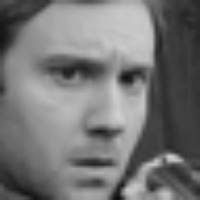

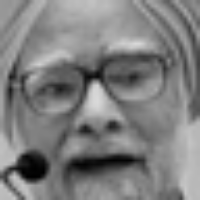

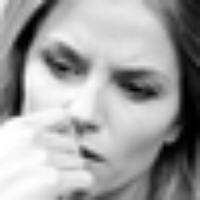

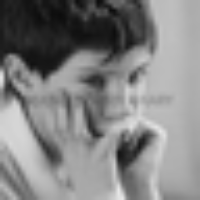

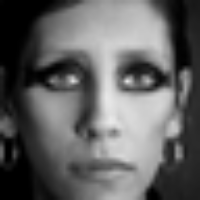

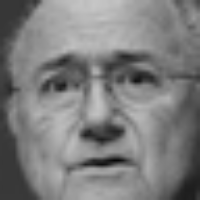

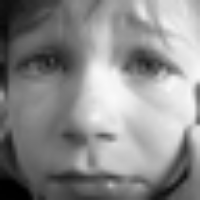

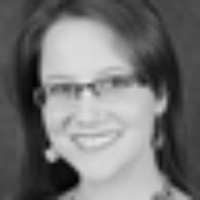

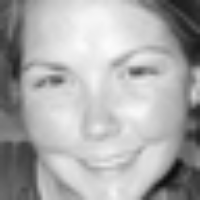

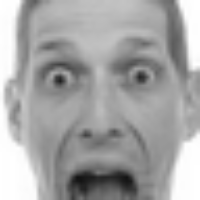

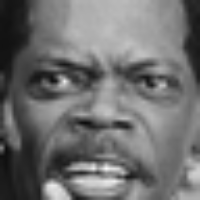

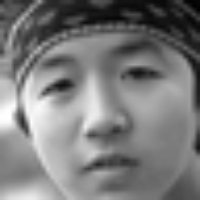

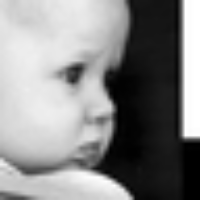

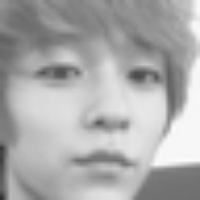

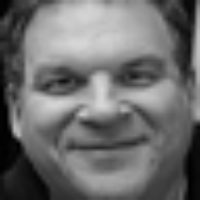

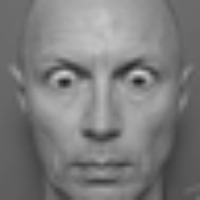

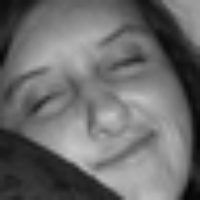

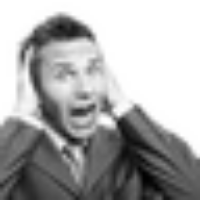

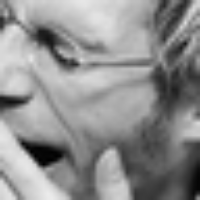

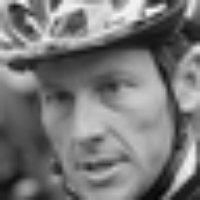

In [26]:
for x in x_train[:20]:
  px=x.reshape(48,48)
  px=cv2.resize(px,(200,200))
  cv2_imshow(px)

#Data Augmentation

In [43]:
from keras.preprocessing.image import ImageDataGenerator

datagen= ImageDataGenerator(
    rescale=1./255, #rescaling
    rotation_range=10,#rotating the image
    horizontal_flip=True,#flipping the image horizontally
    width_shift_range=0.1,
    height_shift_range=0.1, #shift in width and height
    fill_mode='nearest'
)
valgen=ImageDataGenerator(rescale=1./255)
testgen= ImageDataGenerator(rescale=1./255)

In [44]:
datagen.fit(x_train)

In [45]:
train_flow=datagen.flow(x_train,y_train,batch_size=64)#augmenting training set images.
val_flow=valgen.flow(x_val,y_val,batch_size=64) #normalizing val and test dataset.
test_flow=testgen.flow(x_test,y_test,batch_size=64)

#Building models using keras layers and keras sequential model

In [ ]:
pip install visualkeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 992 kB 5.1 MB/s 


In [49]:
from keras.models import Model
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate

from keras.regularizers import l1, l2
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from visualkeras import layered_view, graph_view

#Model 1

In [ ]:
def FER_Model(input_shape=(48,48,1)):
    # first input model
    visible = Input(shape=input_shape, name='input')

    #the 1-st block
    conv1_1 = Conv2D(32, kernel_size=3, strides=(1,1),activation='relu', name = 'conv1_1')(visible)
    pool1_1 = MaxPooling2D(pool_size=(2,2), name = 'pool1_1')(conv1_1)
    conv1_1 = BatchNormalization()(pool1_1)

    #the 2-nd block
    conv2_1 = Conv2D(64, kernel_size=3, strides=(1,1),activation='relu',name = 'conv2_1')(conv1_1)
    pool2_1 = MaxPooling2D(pool_size=(2,2), name = 'pool2_1')(conv2_1)
    conv2_1 = BatchNormalization()(pool2_1)

    #the 3-rd block
    conv3_1 = Conv2D(128, kernel_size=3,strides=(1,1), activation='relu', name = 'conv3_1')(pool2_1)
    pool3_1 = MaxPooling2D(pool_size=(2,2), name = 'pool3_1')(conv3_1)
    conv3_1 = BatchNormalization()(pool3_1)

    #Flatten and output
    flatten = Flatten(name = 'flatten')(conv3_1)
    drop1 = Dense(480, activation='relu', name = 'drop1')(flatten)
    drop2 = Dense(240, activation='relu', name = 'drop2')(drop1)
    ouput = Dense(7, activation='softmax', name = 'output')(drop2)

    # create model 
    model = Model(inputs =visible, outputs = ouput)
    
    # summary layers
    print(model.summary())
    
    return model

In [ ]:
model=FER_Model()
opt=tf.keras.optimizers.Adam(lr=0.0001,decay=1e-6)
model.compile(loss='categorical_crossentropy',optimizer=opt, metrics=['accuracy'])

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 48, 48, 1)]       0         
                                                                 
 conv1_1 (Conv2D)            (None, 46, 46, 32)        320       
                                                                 
 pool1_1 (MaxPooling2D)      (None, 23, 23, 32)        0         
                                                                 
 batch_normalization_10 (Bat  (None, 23, 23, 32)       128       
 chNormalization)                                                
                                                                 
 conv2_1 (Conv2D)            (None, 21, 21, 64)        18496     
                                                                 
 pool2_1 (MaxPooling2D)      (None, 10, 10, 64)        0         
                                                           

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
num_epochs = 200
history = model.fit_generator(train_flow, 
                    steps_per_epoch=len(x_train) / 64, 
                    epochs=num_epochs,  
                    verbose=1,  
                    validation_data=test_flow)


Epoch 1/200
  1/448 [..............................] - ETA: 28s - loss: 1.1463 - accuracy: 0.5781

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


448/448 [==============================] - 12s 26ms/step - loss: 1.2088 - accuracy: 0.5428 - val_loss: 1.1857 - val_accuracy: 0.5439
Epoch 2/200
448/448 [==============================] - 12s 26ms/step - loss: 1.1862 - accuracy: 0.5499 - val_loss: 1.1746 - val_accuracy: 0.5397
Epoch 3/200
448/448 [==============================] - 12s 26ms/step - loss: 1.1676 - accuracy: 0.5562 - val_loss: 1.1707 - val_accuracy: 0.5639
Epoch 4/200
448/448 [==============================] - 12s 26ms/step - loss: 1.1448 - accuracy: 0.5639 - val_loss: 1.1638 - val_accuracy: 0.5573
Epoch 5/200
448/448 [==============================] - 12s 26ms/step - loss: 1.1307 - accuracy: 0.5731 - val_loss: 1.1461 - val_accuracy: 0.5737
Epoch 6/200
448/448 [==============================] - 12s 26ms/step - loss: 1.1108 - accuracy: 0.5812 - val_loss: 1.1486 - val_accuracy: 0.5706
Epoch 7/200
448/448 [==============================] - 12s 26ms/step - loss: 1.1001 - accuracy: 0.5852 - val_loss: 1.1099 - val_accuracy: 0.57

In [ ]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
from tensorflow.keras.models import model_from_json
model = model_from_json(open("/content/model.json", "r").read())
model.load_weights('model.h5')
opt=tf.keras.optimizers.Adam(lr=0.0001,decay=1e-6)
model.compile(loss='categorical_crossentropy',optimizer=opt, metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
#total loss and accuracy in training the dataset on test set
score = model.evaluate(x_test/255., y_test, verbose=1) 
print("Test Loss: ", (score[0]))
print("Test Accuracy: ",  score[1]*100)

113/113 [==============================] - 3s 24ms/step - loss: 1.5443 - accuracy: 0.6475
Test Loss:  1.5442514419555664
Test Accuracy:  64.75341320037842


The model has exhibited hight training accuracy but low val, test accuracy. The model has clearly overfitted the dataset. We will deploy some regualarization techniques in next models.

In [ ]:
plt.plot(history.history['loss'], label="Training_set")
plt.plot(history.history['val_loss'], label="Validation set")
plt.title("Model loss", size=16)
plt.ylabel("Total Loss", size=14)
plt.xlabel("Epochs", size=14)
plt.legend()
plt.show()

NameError: ignored

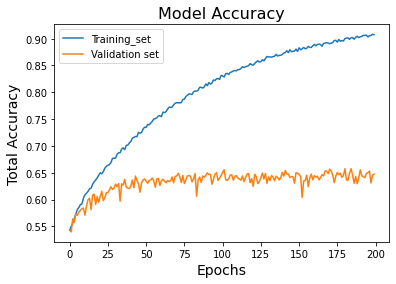

In [ ]:
plt.plot(history.history['accuracy'], label="Training_set")
plt.plot(history.history['val_accuracy'], label="Validation set")
plt.title("Model Accuracy", size=16)
plt.ylabel("Total Accuracy", size=14)
plt.xlabel("Epochs", size=14)
plt.legend()
plt.show()

In [ ]:
from keras.preprocessing import image
def pred_emotion(img_path):
  emotion_dict = {0: 'anger', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'sad',5: 'suprise', 6: 'neutral'}
  
  img = image.load_img(img_path, grayscale=True, target_size=(48,48))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  prediction = np.argmax(model.predict(x))
  print('The predicted emotion is : ' + emotion_dict[prediction])
  my_image = image.load_img(img_path)
  plt.imshow(my_image)
  result = plt.show()
  return result

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


The predicted emotion is : happy


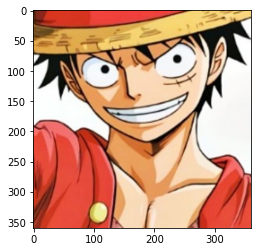

In [ ]:
pred_emotion("/content/drive/MyDrive/Cloudy ML/opencv/image1.jpg")

113/113 [==============================] - 4s 33ms/step


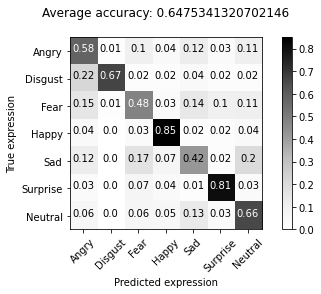

In [ ]:
classes=np.array(("Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"))
import itertools 
def plot_confusion_matrix(y_test, y_pred, classes,
                          normalize=False,
                          title='Unnormalized confusion matrix',
                          cmap=plt.cm.Blues):
    cm = confusion_matrix(y_test, y_pred)
    
    if normalize:
        cm = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], 2)
        
    np.set_printoptions(precision=2)
        
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.min() + (cm.max() - cm.min()) / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True expression')
    plt.xlabel('Predicted expression')
    plt.show()
y_pred_ = model.predict(x_test/255., verbose=1)
y_pred = np.argmax(y_pred_, axis=1)
t_te = np.argmax(y_test, axis=1)
fig = plot_confusion_matrix(y_test=t_te, y_pred=y_pred,
                      classes=classes,
                      normalize=True,
                      cmap=plt.cm.Greys,   title='Average accuracy: ' + str(np.sum(y_pred == t_te)/len(t_te)) + '\n')

#Model 2

In [ ]:
#designing CNN. 

model_fer_1 = Sequential()

model_fer_1.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(48,48,1)))
model_fer_1.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
model_fer_1.add(BatchNormalization())
model_fer_1.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model_fer_1.add(Dropout(0.5))

model_fer_1.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))
model_fer_1.add(BatchNormalization())
model_fer_1.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))
model_fer_1.add(BatchNormalization())
model_fer_1.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model_fer_1.add(Dropout(0.5))

model_fer_1.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'))
model_fer_1.add(BatchNormalization())
model_fer_1.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'))
model_fer_1.add(BatchNormalization())
model_fer_1.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model_fer_1.add(Dropout(0.5))

model_fer_1.add(Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same'))
model_fer_1.add(BatchNormalization())
model_fer_1.add(Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same'))
model_fer_1.add(BatchNormalization())
model_fer_1.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model_fer_1.add(Dropout(0.5))

model_fer_1.add(Flatten())

model_fer_1.add(Dense(512, activation='relu'))
model_fer_1.add(Dropout(0.4))
model_fer_1.add(Dense(256, activation='relu'))
model_fer_1.add(Dropout(0.4))
model_fer_1.add(Dense(128, activation='relu'))
model_fer_1.add(Dropout(0.5))
model_fer_1.add(Dense(7, activation='softmax'))
model_fer_1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 46, 46, 64)        640       
                                                                 
 conv2d_9 (Conv2D)           (None, 46, 46, 64)        36928     
                                                                 
 batch_normalization_13 (Bat  (None, 46, 46, 64)       256       
 chNormalization)                                                
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 23, 23, 64)       0         
 2D)                                                             
                                                                 
 dropout_7 (Dropout)         (None, 23, 23, 64)        0         
                                                                 
 conv2d_10 (Conv2D)          (None, 23, 23, 128)      

Note: This model architecture is inspired from AnlayticsVidhya.com tutorial:

https://www.analyticsvidhya.com/blog/2021/11/facial-emotion-detection-using-cnn/



In [ ]:
model=model_fer_1
opt=tf.keras.optimizers.Adam(learning_rate=0.0001,decay=1e-6)
model.compile(loss='categorical_crossentropy',optimizer=opt, metrics=['accuracy'])

In [ ]:
num_epochs = 100
history = model.fit(train_flow, 
                    steps_per_epoch=len(x_train) / 64, 
                    epochs=num_epochs,  
                    verbose=1,  
                    validation_data=test_flow)


Epoch 1/100
  4/448 [..............................] - ETA: 30:24 - loss: 5.4562 - accuracy: 0.1875

KeyboardInterrupt: ignored

In [29]:
model_json = model_fer_1.to_json()
with open("model_fer_1.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("model_fer_1.h5")
print("Saved model to disk")

NameError: ignored

In [46]:
from tensorflow.keras.models import model_from_json
model = model_from_json(open("/content/model_fer_1.json", "r").read())
model.load_weights('model_fer_1.h5')
opt=tf.keras.optimizers.Adam(lr=0.0001,decay=1e-6)
model.compile(loss='categorical_crossentropy',optimizer=opt, metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [47]:
#total loss and accuracy in training the dataset on test set
score = model.evaluate(x_test/255., y_test, verbose=1) 
print("Test Loss: ", (score[0]))
print("Test Accuracy: ",  score[1]*100)
      

113/113 [==============================] - 54s 467ms/step - loss: 0.9044 - accuracy: 0.6668
Test Loss:  0.9043590426445007
Test Accuracy:  66.67595505714417


The model exhibits high training accuracy but low val and test accuracy. Indicating overfitting. 

In [52]:
from keras.preprocessing import image
def pred_emotion(img_path):
  emotion_dict = {0: 'Angry', 1: 'Disgusted', 2: 'Fearful', 3: 'Happy', 4: 'Sad',5: 'Surprised', 6: 'Neutral'}
  img = image.load_img(img_path, grayscale=True, target_size=(48,48))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  prediction = np.argmax(model.predict(x))
  print('The predicted emotion is : ' + emotion_dict[prediction])
  my_image = image.load_img(img_path)
  plt.imshow(my_image)
  result = plt.show()
  return result

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


The predicted emotion is : anger


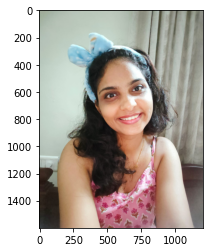

In [53]:
pred_emotion("/content/drive/MyDrive/Cloudy ML/opencv/happy aishu2.jfif")

The model is classifying this happy image as anger

#Model 3

In [ ]:
def FER_Model(input_shape=(48,48,1)):
    # first input model
    visible = Input(shape=input_shape, name='input')

    #the 1-st block
    conv1_1 = Conv2D(32, kernel_size=3, strides=(1,1),activation='relu', name = 'conv1_1')(visible)
    pool1_1 = MaxPooling2D(pool_size=(2,2), name = 'pool1_1')(conv1_1)
    conv1_1 = BatchNormalization()(pool1_1)
    conv1_1=Dropout(0.5)(conv1_1)

    #the 2-nd block
    conv2_1 = Conv2D(64, kernel_size=3, strides=(1,1),activation='relu',name = 'conv2_1')(conv1_1)
    pool2_1 = MaxPooling2D(pool_size=(2,2), name = 'pool2_1')(conv2_1)
    conv2_1 = BatchNormalization()(pool2_1)
    conv2_1= Dropout(0.5)(conv2_1)

    #the 3-rd block
    conv3_1 = Conv2D(128, kernel_size=3,strides=(1,1), activation='relu', name = 'conv3_1')(pool2_1)
    pool3_1 = MaxPooling2D(pool_size=(2,2), name = 'pool3_1')(conv3_1)
    conv3_1 = BatchNormalization()(pool3_1)
    conv3_1=Dropout(0.5)(conv3_1)

    #Flatten and output
    flatten = Flatten(name = 'flatten')(conv3_1)
    drop1 = Dense(480, activation='relu', name = 'drop1')(flatten)
    drop2 = Dense(240, activation='relu', name = 'drop2')(drop1)
    ouput = Dense(7, activation='softmax', name = 'output')(drop2)

    # create model 
    model = Model(inputs =visible, outputs = ouput)
    
    # summary layers
    print(model.summary())
    
    return model

In [ ]:
model_fer_3=FER_Model()
opt=tf.keras.optimizers.Adam(lr=0.0001,decay=1e-6)
model_fer_3.compile(loss='categorical_crossentropy',optimizer=opt, metrics=['accuracy'])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 48, 48, 1)]       0         
                                                                 
 conv1_1 (Conv2D)            (None, 46, 46, 32)        320       
                                                                 
 pool1_1 (MaxPooling2D)      (None, 23, 23, 32)        0         
                                                                 
 batch_normalization_7 (Batc  (None, 23, 23, 32)       128       
 hNormalization)                                                 
                                                                 
 dropout_4 (Dropout)         (None, 23, 23, 32)        0         
                                                                 
 conv2_1 (Conv2D)            (None, 21, 21, 64)        18496     
                                                             

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
num_epochs = 200
early_stopping=EarlyStopping()
history = model_fer_3.fit(train_flow, 
                    steps_per_epoch=len(x_train) / 64, 
                    epochs=num_epochs,  
                    verbose=1,  
                    validation_data=test_flow,
                    callbacks=[early_stopping])


Epoch 1/200
448/448 [==============================] - 30s 42ms/step - loss: 1.9169 - accuracy: 0.2388 - val_loss: 1.8502 - val_accuracy: 0.2282
Epoch 2/200
448/448 [==============================] - 22s 50ms/step - loss: 1.7861 - accuracy: 0.2766 - val_loss: 1.6756 - val_accuracy: 0.3383
Epoch 3/200
448/448 [==============================] - 26s 58ms/step - loss: 1.7348 - accuracy: 0.3031 - val_loss: 1.6299 - val_accuracy: 0.3547
Epoch 4/200
448/448 [==============================] - 19s 43ms/step - loss: 1.6922 - accuracy: 0.3266 - val_loss: 1.6087 - val_accuracy: 0.3633
Epoch 5/200
448/448 [==============================] - 18s 41ms/step - loss: 1.6599 - accuracy: 0.3426 - val_loss: 1.5714 - val_accuracy: 0.3876
Epoch 6/200
448/448 [==============================] - 18s 41ms/step - loss: 1.6254 - accuracy: 0.3586 - val_loss: 1.6066 - val_accuracy: 0.3809
Epoch 7/200
448/448 [==============================] - 18s 41ms/step - loss: 1.5945 - accuracy: 0.3740 - val_loss: 1.5212 - val_ac

In [ ]:
model_json = model_fer_3.to_json()
with open("model_fer_3.json", "w") as json_file:
    json_file.write(model_json)
model_fer_3.save_weights("model_fer_3.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
#total loss and accuracy in training the dataset on test set
score = model_fer_3.evaluate(x_test/255., y_test, verbose=1) 
print("Test Loss: ", (score[0]))
print("Test Accuracy: ",  score[1]*100)

113/113 [==============================] - 2s 13ms/step - loss: 0.9927 - accuracy: 0.6459
Test Loss:  0.9926576614379883
Test Accuracy:  64.5862340927124


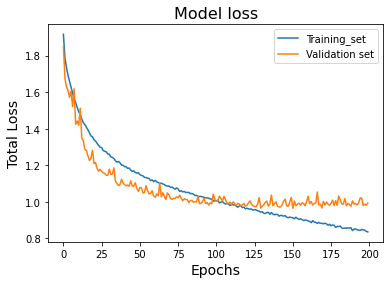

In [ ]:
plt.plot(history.history['loss'], label="Training_set")
plt.plot(history.history['val_loss'], label="Validation set")
plt.title("Model loss", size=16)
plt.ylabel("Total Loss", size=14)
plt.xlabel("Epochs", size=14)
plt.legend()
plt.show()

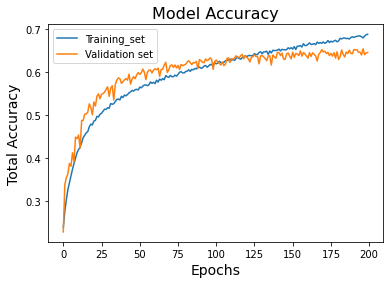

In [ ]:
plt.plot(history.history['accuracy'], label="Training_set")
plt.plot(history.history['val_accuracy'], label="Validation set")
plt.title("Model Accuracy", size=16)
plt.ylabel("Total Accuracy", size=14)
plt.xlabel("Epochs", size=14)
plt.legend()
plt.show()

In [ ]:
from keras.preprocessing import image
def pred_emotion(img_path):
  emotion_dict = {0: 'anger', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'sad',5: 'suprise', 6: 'neutral'}
  img = image.load_img(img_path, grayscale=True, target_size=(48,48))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  prediction = np.argmax(model_fer_3.predict(x))
  print('The predicted emotion is : ' + emotion_dict[prediction])
  my_image = image.load_img(img_path)
  plt.imshow(my_image)
  result = plt.show()
  return result

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


The predicted emotion is : anger


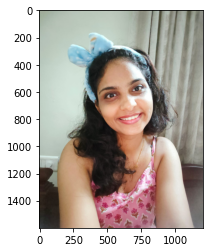

In [ ]:
pred_emotion("/content/drive/MyDrive/Cloudy ML/opencv/happy aishu2.jfif")

#Model 4

In [ ]:
from keras.regularizers import l2

In [ ]:
model_fer_4 = Sequential()

model_fer_4.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(48,48,1)))
model_fer_4.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
model_fer_4.add(BatchNormalization())
model_fer_4.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model_fer_4.add(Dropout(0.25))

model_fer_4.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))
model_fer_4.add(BatchNormalization())
model_fer_4.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))
model_fer_4.add(BatchNormalization())
model_fer_4.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model_fer_4.add(Dropout(0.3))

model_fer_4.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'))
model_fer_4.add(BatchNormalization())
model_fer_4.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'))
model_fer_4.add(BatchNormalization())
model_fer_4.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model_fer_4.add(Dropout(0.3))

model_fer_4.add(Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same'))
model_fer_4.add(BatchNormalization())
model_fer_4.add(Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same'))
model_fer_4.add(BatchNormalization())
model_fer_4.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model_fer_4.add(Dropout(0.3))

model_fer_4.add(Flatten())
model_fer_4.add(Dense(7, activation='softmax'))

model_fer_4.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 64)        640       
                                                                 
 conv2d_1 (Conv2D)           (None, 46, 46, 64)        36928     
                                                                 
 batch_normalization (BatchN  (None, 46, 46, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 23, 23, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 23, 23, 128)       7

In [ ]:
opt=tf.keras.optimizers.Adam(lr=0.0001,decay=1e-6)
model_fer_4.compile(loss='categorical_crossentropy',optimizer=opt, metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
from keras.callbacks import EarlyStopping

In [ ]:
num_epochs = 200
early_stopping=EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15, restore_best_weights=True)
history = model_fer_4.fit(train_flow, 
                    steps_per_epoch=len(x_train) / 64, 
                    epochs=num_epochs,  
                    verbose=1,  
                    validation_data=val_flow,
                    callbacks=[early_stopping])


Epoch 1/200
448/448 [==============================] - 21s 48ms/step - loss: 2.1871 - accuracy: 0.2491 - val_loss: 1.7847 - val_accuracy: 0.3026
Epoch 2/200
448/448 [==============================] - 22s 49ms/step - loss: 1.9948 - accuracy: 0.2802 - val_loss: 1.6322 - val_accuracy: 0.3789
Epoch 3/200
448/448 [==============================] - 20s 45ms/step - loss: 1.7990 - accuracy: 0.3285 - val_loss: 1.5842 - val_accuracy: 0.3803
Epoch 4/200
448/448 [==============================] - 20s 44ms/step - loss: 1.6562 - accuracy: 0.3689 - val_loss: 2.5260 - val_accuracy: 0.2914
Epoch 5/200
448/448 [==============================] - 20s 45ms/step - loss: 1.5502 - accuracy: 0.4036 - val_loss: 1.4090 - val_accuracy: 0.4592
Epoch 6/200
448/448 [==============================] - 20s 45ms/step - loss: 1.4750 - accuracy: 0.4366 - val_loss: 1.7893 - val_accuracy: 0.4185
Epoch 7/200
448/448 [==============================] - 20s 45ms/step - loss: 1.4096 - accuracy: 0.4626 - val_loss: 1.4031 - val_ac

In [ ]:
model_json = model_fer_4.to_json()
with open("model_fer_4.json", "w") as json_file:
    json_file.write(model_json)
model_fer_4.save_weights("model_fer_4.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
#total loss and accuracy in training the dataset on test set
score = model_fer_4.evaluate(x_test/255., y_test, verbose=1) 
print("Test Loss: ", (score[0]))
print("Test Accuracy: ",  score[1]*100)

113/113 [==============================] - 2s 10ms/step - loss: 0.8991 - accuracy: 0.6709
Test Loss:  0.8991346955299377
Test Accuracy:  67.09389686584473


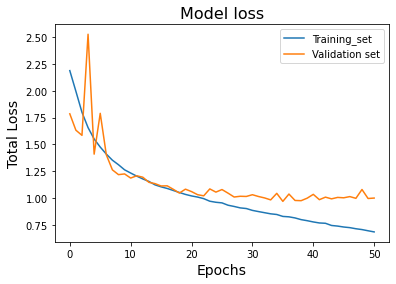

In [ ]:
plt.plot(history.history['loss'], label="Training_set")
plt.plot(history.history['val_loss'], label="Validation set")
plt.title("Model loss", size=16)
plt.ylabel("Total Loss", size=14)
plt.xlabel("Epochs", size=14)
plt.legend()
plt.show()

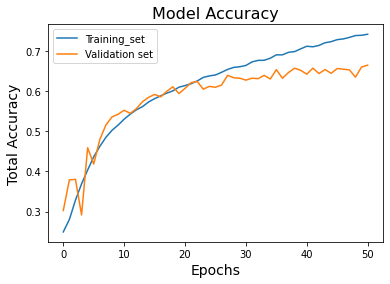

In [ ]:
plt.plot(history.history['accuracy'], label="Training_set")
plt.plot(history.history['val_accuracy'], label="Validation set")
plt.title("Model Accuracy", size=16)
plt.ylabel("Total Accuracy", size=14)
plt.xlabel("Epochs", size=14)
plt.legend()
plt.show()

In [ ]:
from tensorflow.keras.models import model_from_json
model = model_from_json(open("/content/model_fer_4.json", "r").read())
model.load_weights('model_fer_4.h5')
opt=tf.keras.optimizers.Adam(lr=0.0001,decay=1e-6)
model.compile(loss='categorical_crossentropy',optimizer=opt, metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
from keras.preprocessing import image
def pred_emotion(img_path):
  emotion_dict = {0: 'anger', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'sad',5: 'suprise', 6: 'neutral'}
  img = image.load_img(img_path, color_mode='grayscale', target_size=(48,48))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  prediction = np.argmax(model.predict(x))
  print('The predicted emotion is : ' + emotion_dict[prediction])
  my_image = image.load_img(img_path)
  plt.imshow(my_image)
  result = plt.show()
  return result

The predicted emotion is : happy


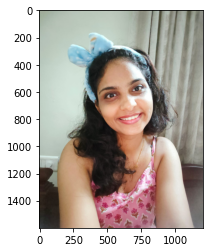

In [ ]:
pred_emotion("/content/drive/MyDrive/Cloudy ML/opencv/happy aishu2.jfif")

The predicted emotion is : anger


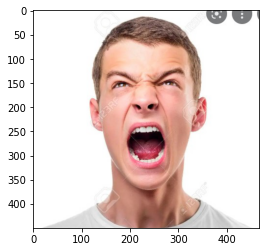

In [ ]:
pred_emotion('/content/drive/MyDrive/Cloudy ML/opencv/angry.jpg')

The predicted emotion is : anger


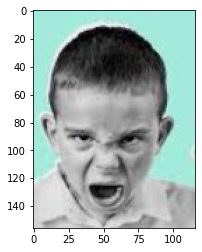

In [ ]:
pred_emotion('/content/drive/MyDrive/Cloudy ML/opencv/anger5.jpg')

113/113 [==============================] - 59s 524ms/step


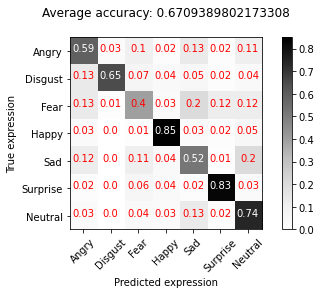

In [ ]:
classes=np.array(("Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"))
import itertools 
def plot_confusion_matrix(y_test, y_pred, classes,
                          normalize=False,
                          title='Unnormalized confusion matrix',
                          cmap=plt.cm.Blues):
    cm = confusion_matrix(y_test, y_pred)
    
    if normalize:
        cm = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], 2)
        
    np.set_printoptions(precision=2)
        
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.min() + (cm.max() - cm.min()) / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "red")

    plt.tight_layout()
    plt.ylabel('True expression')
    plt.xlabel('Predicted expression')
    plt.show()
y_pred_ = model.predict(x_test/255., verbose=1)
y_pred = np.argmax(y_pred_, axis=1)
t_te = np.argmax(y_test, axis=1)
fig = plot_confusion_matrix(y_test=t_te, y_pred=y_pred,
                      classes=classes,
                      normalize=True,
                      cmap=plt.cm.Greys,   title='Average accuracy: ' + str(np.sum(y_pred == t_te)/len(t_te)) + '\n')

#Visualisation

In [ ]:
pip install ann_visualizer


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for ann-visualizer: filename=ann_visualizer-2.5-py3-none-any.whl size=4168 sha256=30f042425c1c206cbd4608328dc7d980a05a61a53d3936ac198826a691be5e74
  Stored in directory: /root/.cache/pip/wheels/1b/fc/58/2ab1c3b30350105929308becddda4fb59b1358e54f985e1f4a
Successfully built ann-visualizer


In [ ]:
pip install graphviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from keras.utils.vis_utils import plot_model

In [ ]:
from ann_visualizer.visualize import ann_viz;


ann_viz(model_fer_4, title="My first neural network")

IndexError: ignored

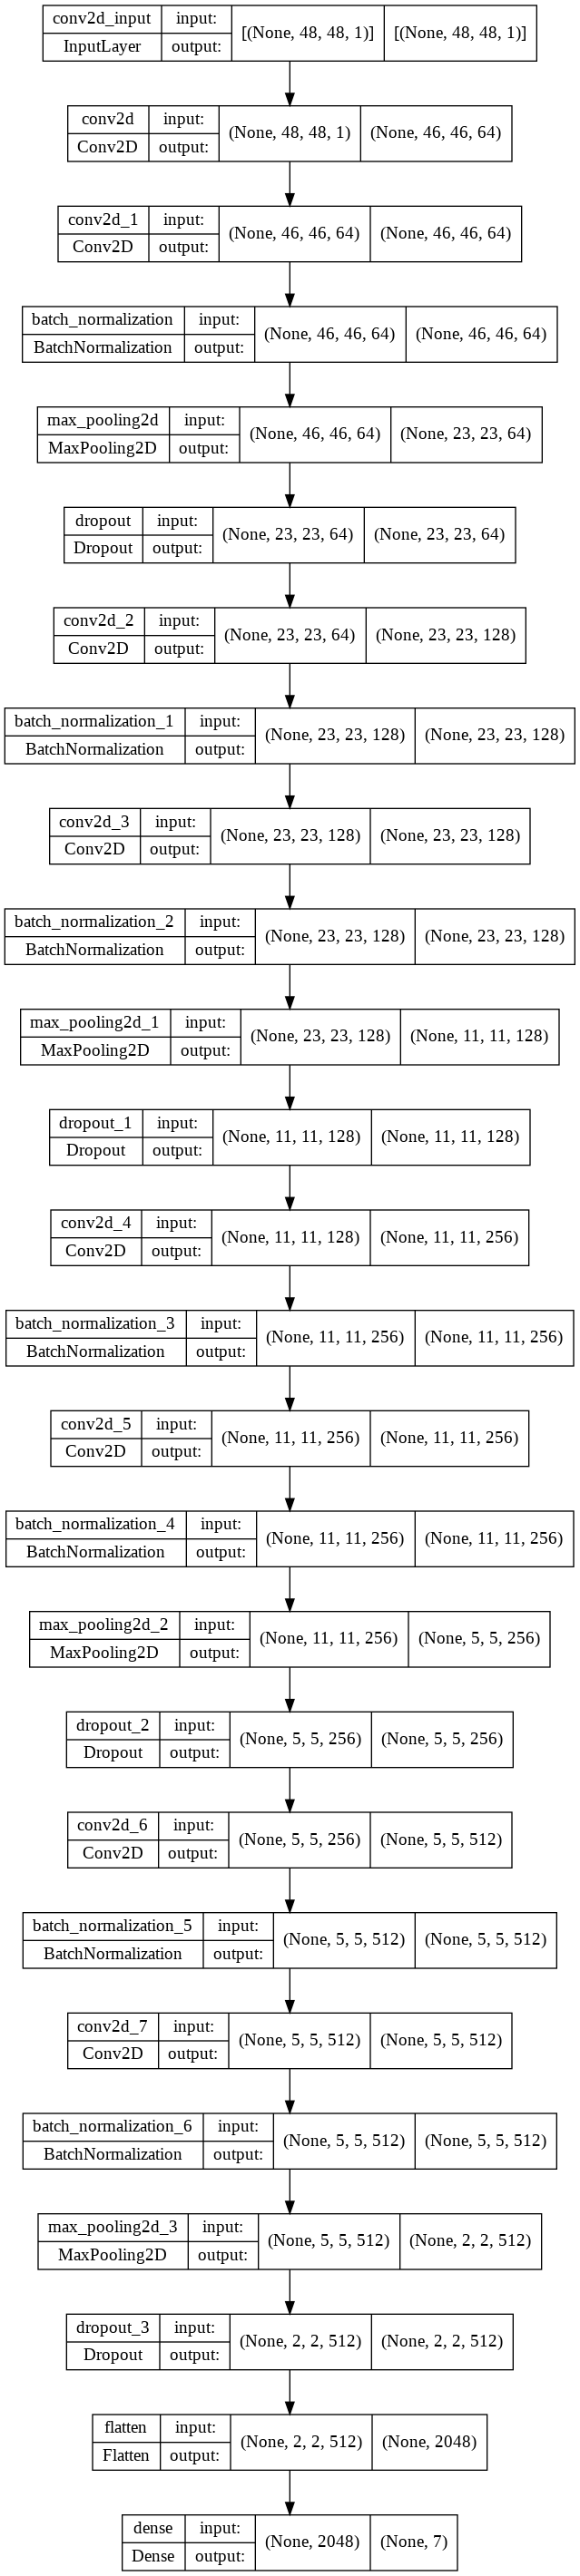

In [ ]:
plot_model(model_fer_4, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
pip install visualkeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 992 kB 4.0 MB/s 


In [ ]:
from visualkeras import layered_view, graph_view

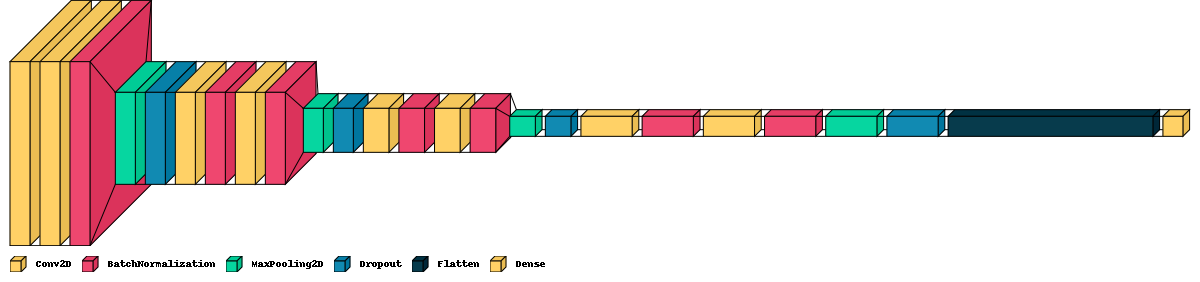

In [ ]:
layered_view(model_fer_4,legend=True) 

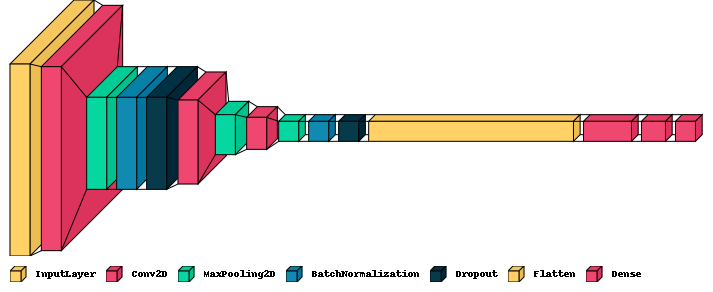

In [ ]:
layered_view(model_fer_3,legend=True) 

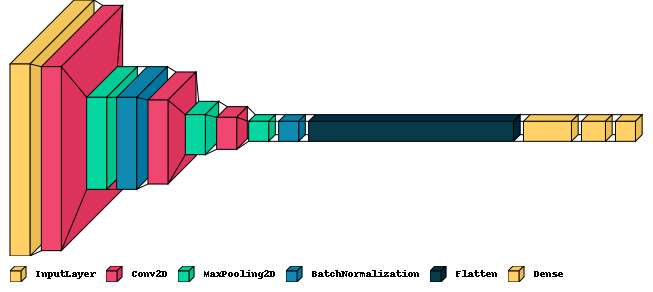

In [ ]:
layered_view(model,legend=True) 

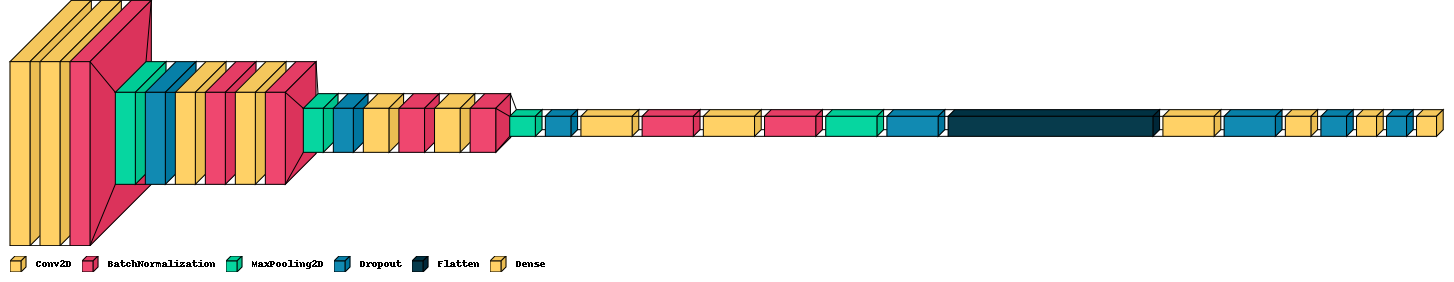

In [ ]:
layered_view(model_fer_1,legend=True) 